In [1]:
import numpy as np
import matplotlib.pyplot as plt

\begin{equation}
H=-\frac{\hbar}{2m}\sum_{i}\frac{d^{2}}{dx^{2}}+\frac{1}{2}m\omega_{0}^{2}\sum_{i}x_{i}^{2}+\frac{1}{2}m\omega_{int}^{2}\sum_{i<j}\left(x_{i}-x_{j}\right)^{2}
\end{equation}


In [2]:
def displace(Path,α,i,δ=0.75):
    '''Single bead displace update.
    
       NB: not implemented for periodic boundary conditions.
    '''
    # Calculate the action
    x = Path.beads[α,i]
    oldAction = Path.kinetic_action(α,i) + Path.potential_action(α)

    # Displace the bead
    Path.beads[α,i] += δ*(-1.0 + 2.0*np.random.random())

    # Compute the new action
    newAction = Path.kinetic_action(α,i) + Path.potential_action(α)
    
    # Accept the move, or reject and restore the bead position
    if np.random.random() < np.exp(-(newAction - oldAction)):
        return True
    else:
        Path.beads[α,i] = x
        return False

In [3]:
def staging(Path,m,i):
    '''Multi-slice update which eactly samples the free particle 
       propagator between two fixed beads.

       See: http://link.aps.org/doi/10.1103/PhysRevB.31.4234
    
       NB: not implemented for periodic boundary conditions.
    '''
    # choose the start and end of the stage
    α_start = np.random.randint(low=0,high=Path.num_time_slices)
    α_end = α_start + m
    
    # if we move off the end of the path, reject the move
    if α_end >= Path.num_time_slices:
        return False

    # Record the positions of the beads to be updated and store the action
    x = np.copy(Path.beads[α_start+1:α_end,i])
    oldAction = 0.0
    for α in range(α_start+1,α_end):
        oldAction += Path.potential_action(α)

    # Generate new positions and accumulate the new action
    newAction = 0.0;
    for α in range(α_start+1,α_end):
        Δτ1 = Path.Δτ   
        Δτ2 = (α_end - α)*Path.Δτ
        avex = (Δτ2*Path.beads[α-1,i] + Δτ1*Path.beads[α_end,i])\
                / (Δτ1 + Δτ2)
        σ = np.sqrt(2.0*Path.λ / (1.0/Δτ1 + 1.0/Δτ2))
        Path.beads[α,i] = np.random.normal(loc=avex,scale=σ)
        newAction += Path.potential_action(α)

    # Perform the Metropolis step, if we reject, revert the worldline
    if np.random.random() < np.exp(-(newAction - oldAction)):
        return True
    else:
        Path.beads[α_start+1:α_end,i] = x
        return False

In [4]:
def pigs(num_MC_steps,num_equil_steps,Path,m=8):
    '''Perform a path integral ground state Monte Carlo simulation.'''

    # initialize estimators and acceptance counters
    numAccept = {'displace':0,'staging':0}
    estimator = {'E':np.zeros(num_MC_steps-num_equil_steps),
                 'Eslice':np.zeros([num_MC_steps-num_equil_steps,Path.num_time_slices])}

    measure = 0
    for step in range(num_MC_steps): 
        
        # for each particle and slice try a displace move
        for α in range(Path.num_time_slices):
            for i in range(Path.N):
                numAccept['displace'] += displace(Path,α,i)

        # for each particle try a number of staging moves
        num_stage = int(Path.num_time_slices/m)
        for stage in range(num_stage):
            for i in range(Path.N): 
                numAccept['staging'] += staging(Path,m,i)

        # measure the energy
        if step >= num_equil_steps:
            measure = step-num_equil_steps
            estimator['E'][measure],estimator['Eslice'][measure] = Path.Energy()
                     
    print('displace: %4.3f' %
          ((1.0*numAccept['displace'])/(num_MC_steps*Path.num_time_slices*Path.N)))
    print('staging:  %4.3f' %
          ((1.0*numAccept['staging'])/(num_MC_steps*Path.N*num_stage)))
    
    return estimator

In [5]:
class Paths:
    '''The set of worldlines, action and estimators.'''
    def __init__(self,beads,M,Δτ,λ,ω0,ω1):
        self.Δτ = Δτ
        self.λ = λ
        self.M = M
        self.beads = np.copy(beads)
        self.num_time_slices = len(beads)
        self.N = len(beads[0])
        self.ω0 = ω0
        self.ω1 = ω1
        self.norm = np.ones(self.num_time_slices)
        
        self.norm[0] = self.norm[-1] = 0.5
        
    def V(self,x):
        '''harmonic oscillator potential'''
        ω = self.ω0
        return ω*ω*x*x /(4.0*self.λ)
    
    def dV(self,x):
        ω = self.ω0
        return ω*ω*x /(2.0*self.λ)
    
    def ddV(self,x):
        ω = self.ω0
        return ω*ω /(2.0*self.λ)
    
    def Vint(self, xi, xj):
        '''harmonic interaction potential'''
        ω = self.ω1
        return ω*ω*(xi-xj)**2 /(4.0*self.λ)
    
    def Ψ(self, xi, xj):
        '''trial wave function'''
        return 1.0/np.cosh(np.sqrt(np.pi/2)*xi)
#         η = np.sqrt(1 + self.N*self.ω1**2/self.ω0**2)
#         σ0 = np.sqrt(2*self.λ/self.ω0)
#         return η**(1/4)/np.sqrt(np.pi)*np.exp(-1/(2*σ0**2)*((1+η)*(xi**2+xj**2)/2+(1-η)*xi*xj)) 
    
    def kinetic_action(self,α,i):
        '''kinetic action of a bead.'''
        
        if α == 0.0:
            cK = (self.beads[α+1,i]-self.beads[α,i])**2
        elif α == 2*self.M:
            cK = (self.beads[α,i]-self.beads[α-1,i])**2
        else:
            cK = (self.beads[α,i]-self.beads[α-1,i])**2 + (self.beads[α+1,i]-self.beads[α,i])**2
        return cK / (4*self.λ*self.Δτ)

    def potential_action(self,α):
        '''potential action of a slice.'''
        cV = 0.0
        ΨT = 1.0
            
        for i in range(self.N):
            xi = self.beads[α,i]
            cV += self.norm[α]*self.V(xi)
            
            for j in range(self.N):
                xj = self.beads[α,j]
                if i<j:
                    cV += self.norm[α]*self.Vint(xi, xj)    
                # add the wavefunction at the ends of the path
                if α == 0 or α == 2*self.M:
                    ΨT *= self.Ψ(xi, xj)
                
        return self.Δτ*cV - np.log(ΨT)
    

    def Energy(self):
        '''The total energy.'''
                
        # the kinetic part
        norm2 = 1.0/(4.0*self.λ*self.Δτ**2)
        KE = 0.0
        KEslice = np.zeros(self.num_time_slices)
        counter = 0
        M = self.M
        for α in range(self.num_time_slices-1):
            for i in range(self.N):
                counter += 1
                ΔR = self.beads[α+1,i] - self.beads[α,i]
                KEslice[α] +=  - norm2*np.dot(ΔR,ΔR)
            KEslice[α] += 0.5*self.N/self.Δτ
        for α in range(M-1, M+1):
            KE += KEslice[α]
        KE /= 2
        
        # the potential part
        PE = 0.0
        cV = 0.0
        counter2 = 0
        Vslice = np.zeros(self.num_time_slices)
        for α in range(self.num_time_slices-1):
            for i in range(self.N):
                counter2 += 1
                cV = self.V(self.beads[α+1,i])
                cV -= (self.beads[α+1,i]-self.beads[α,i])*self.dV(self.beads[α+1,i])/2
                cV += self.λ*self.Δτ*self.ddV(self.beads[α+1,i])/2
                cV -= self.λ*(self.Δτ*self.dV(self.beads[α+1,i])/2)**2
                for j in range(self.N):
                    if i<j:
                        cV += self.Vint(self.beads[α,i], self.beads[α,j])
                Vslice[α] += cV
                PE += cV
                
        
        PE /= counter2
        
        Eslice = np.add(KEslice, Vslice)
               
        
        return KE + PE, Eslice

In [6]:
# setup the simulation
M,N,τ,λ,ω0,ω1 = 10,1,4.0,0.5,1.0,0.0
Δτ = τ/M

# random initial positions
np.random.seed(1173)
beads = -0.5 + np.random.random([2*M+1,N])

# setup the paths
Path = Paths(beads,M,Δτ,λ,ω0,ω1)

# compute the energy via path integral ground state Monte Carlo
num_MC_steps = 40000
num_equil_steps = 10000
estimator = pigs(num_MC_steps,num_equil_steps,Path)

from scipy.stats import sem
Ē,ΔĒ = np.average(estimator['E']),sem(estimator['E'])
V̄slice,ΔV̄slice = np.average(estimator['Eslice'],axis=0),sem(estimator['Eslice'],axis=0)

print('Ē = %f ± %f' % (Ē,ΔĒ))

displace: 0.678
staging:  0.406
Ē = 0.513272 ± 0.005839


In [7]:
def E_gs(Path):
    eta = np.sqrt(1.0 + (N)*(ω1 / ω0)**2)
    return ω0/2*(1+(N-1)*eta)

analytical_E = E_gs(Path)
print(analytical_E)

0.5


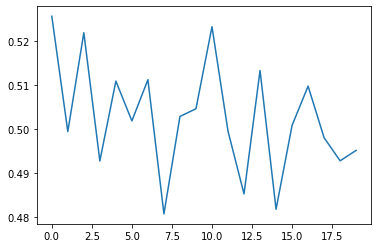

In [9]:
plt.plot(np.arange(2*M) ,V̄slice[:-1])

In [41]:
def cumulativeMovingAverage(data):
    '''Compute the cumulative mean as a function of bin index.'''
    CMA = np.zeros_like(data)
    CMA[0] = data[0]
    for n in range(len(data)-1):
        CMA[n+1] = (data[n+1] + n*CMA[n])/(1.0*(n+1))
    return CMA

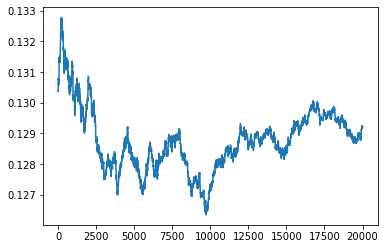

In [42]:
cumave = cumulativeMovingAverage(estimator['E'])
plt.plot(cumave[10000:])

check beta dependence, compute energy for many different beta, see if it exponentially decays, check if decay rate depends on the trial wavefunction 

check how energy depends on $\Delta \tau$

Check energy at different imaginary time slices

impliment more estimators, $\langle x \rangle$, etc.

density-density correlation funciton, -> static structure factor